In [1]:
import xarray as xr

import shnitsel as sh
import shnitsel.xarray

## Load ensembles

In [2]:
cpnds = {}
for cpnd in ['C2H4', 'C3H6', 'C4H8']:
    print("\t", cpnd)
    cpnds[cpnd] = sh.parse.read_trajs(f'/traj/SHNITSEL_alkenes/traj_{cpnd}/', kind='sharc', parallel=True)

	 C2H4
Skipped 362 trajectories missing file 'output.dat', IDs: 35 38 39 40 41 42 43 44 45 46 48 49 51 52 53 55 56 59 60 92 93 95 96 97 98 99 100 101 102 103 105 106 107 108 109 110 111 113 114 115 116 117 145 146 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 168 169 170 172 173 174 211 212 213 214 215 216 217 218 219 220 221 222 223 224 226 230 231 232 234 235 268 269 270 271 272 273 274 275 276 277 279 280 281 282 283 285 286 287 288 289 319 321 322 323 324 325 326 327 328 331 332 336 337 338 339 340 341 343 344 380 381 383 385 386 387 388 389 390 392 394 396 397 398 400 401 403 404 405 438 439 440 441 442 443 445 446 449 450 455 457 458 459 460 461 462 463 465 466 500 501 502 503 505 506 507 508 509 510 511 512 513 514 515 516 518 519 520 522 523 524 556 557 560 561 562 563 566 568 569 570 571 572 573 576 579 580 581 582 583 584 585 586 623 624 625 626 627 628 629 630 631 632 634 635 636 637 638 639 640 641 642 643 644 676 677 679 681 682 683 684 685 68

### Checkpoint: loading complete

In [ ]:
for cpnd in cpnds:
    sh.xrhelpers.save_frames(cpnds[cpnd], f'/tmp/raw_{cpnd}.nc')

In [2]:
cpnds = {}
for cpnd in ['C2H4', 'C3H6', 'C4H8_g0']:
    cpnds[cpnd] = sh.xrhelpers.open_frames(f'/nc/2025-05-20/raw_{cpnd}.nc').sh.setup_frames()
cpnds['C4H8'] = cpnds['C4H8_g0']
del(cpnds['C4H8_g0'])

In [4]:
for cpnd in cpnds:
    cpnds[cpnd] = cpnds[cpnd].sh.setup_frames()

## Filter alkenes by energy

In [5]:
feat = cpnds['C2H4'].sh.energy_filtranda()
feat

<xarray.Dataset> Size: 14MB
Dimensions:     (frame: 172718)
Coordinates:
  * frame       (frame) object 1MB MultiIndex
  * time        (frame) float64 1MB 0.0 0.5 1.0 1.5 ... 167.5 168.0 168.5 169.0
  * trajid      (frame) int64 1MB 2 2 2 2 2 2 2 ... 962 962 962 962 962 962 962
Data variables:
    e_kin       (frame) float64 1MB 0.1839 0.4249 0.7293 ... 1.721 1.74 1.741
    e_pot       (frame) float64 1MB 10.23 9.977 9.665 ... 8.457 8.437 8.436
    e_tot       (frame) float64 1MB 10.41 10.4 10.39 10.39 ... 10.18 10.18 10.18
    etot_drift  (frame) float64 1MB 0.0 0.0102 0.01853 ... 0.02836 0.02933
    ekin_step   (frame) float64 1MB 0.0 0.2411 0.3043 ... 0.01861 0.0006498
    epot_step   (frame) float64 1MB 0.0 -0.2513 -0.3127 ... -0.01943 -0.001618
    etot_step   (frame) float64 1MB 0.0 -0.0102 ... -0.0008267 -0.0009679
    is_hop      (frame) bool 173kB False False False False ... False False False
Attributes:
    delta_t:  0.5

In [6]:
import numpy as np

def last_time_where(mask):
    mask = mask.unstack('frame', fill_value=False).transpose('trajid', 'time', ...)
    idxs = np.logical_not((~mask.values).cumsum(axis=1)).sum(axis=1)
    times = np.concat([[-1], mask.time.values])
    return mask[:, 0].copy(data=times[idxs]).drop_vars('time').rename('time')

last_time_where(feat['e_kin'] < 1)

<xarray.DataArray 'time' (trajid: 438)> Size: 4kB
array([ 1.5, -1. ,  1.5,  8. ,  3.5,  1. ,  8. ,  5. , -1. ,  2. , -1. ,
        1. ,  3. ,  2. ,  3. ,  2.5,  1. ,  3.5,  1. ,  2.5,  4. , -1. ,
        5.5,  0.5,  3. , -1. ,  1. ,  3. ,  5. ,  1.5, -1. ,  0.5,  0.5,
        5.5,  1.5,  0.5,  3. ,  1. , -1. ,  6. ,  6.5,  0. ,  1. ,  4. ,
        1.5,  1. ,  2. ,  4.5, -1. ,  2. , -1. ,  3.5,  2. ,  1.5, -1. ,
        1.5,  7.5,  0. ,  4.5,  2.5,  3.5,  2.5,  2. ,  1. , -1. , -1. ,
        0.5,  5. , -1. ,  0.5, -1. ,  3. ,  2. ,  1.5,  2.5, -1. ,  4. ,
        1. ,  2. ,  3.5,  2.5,  3. , -1. ,  0.5,  3. ,  2. ,  1.5,  1.5,
        1.5,  1.5, -1. ,  3. ,  6. ,  2.5, -1. ,  2. ,  2. ,  4. ,  0.5,
        1. ,  3.5,  0.5, -1. ,  2. , -1. ,  3.5,  0.5,  2.5,  3.5, -1. ,
        8. ,  2. , -1. ,  0.5,  3. ,  2.5,  3. ,  2.5,  3.5,  3. ,  3. ,
        1.5,  2. ,  1.5,  2.5, -1. ,  1.5,  2.5, -1. ,  2. ,  2.5,  2. ,
        2.5,  2.5,  3.5,  4. ,  2.5,  4.5,  3. ,  2. ,  2. ,  2. ,  8. ,
        3. ,  0.5,  2. ,  0. ,  3.5, -1. ,  4.5,  3. , 10. ,  2.5, -1. ,
        1.5,  0. ,  3.5, -1. ,  2.5,  0. ,  3. ,  4.5,  1. ,  1.5,  5.5,
        4. ,  2.5,  0. ,  2.5,  1. ,  1.5,  2. ,  1. ,  0. , -1. , -1. ,
        1.5, -1. ,  2. ,  5.5,  4.5,  2. ,  3.5,  3.5,  2.5,  5. ,  0.5,
       -1. , -1. ,  3.5,  1.5,  0. ,  0.5,  3.5,  2. ,  3. ,  1.5,  0. ,
        3. ,  2. ,  2. ,  3.5,  4. ,  4. ,  2.5, -1. ,  6. ,  9. , -1. ,
        3. ,  0.5,  5.5,  3. , -1. ,  1.5,  3. ,  1.5, -1. ,  5.5,  0.5,
        3.5,  0. ,  1. ,  1.5,  1.5, -1. ,  2.5,  3. ,  1.5,  1.5, 12. ,
        6.5,  3. ,  3.5,  2. ,  4. ,  3.5,  4. ,  7.5, -1. ,  4. ,  1. ,
        1.5,  0.5,  0.5,  3.5,  1.5,  2. , -1. ,  5. , -1. ,  1. ,  3.5,
       -1. ,  2.5,  3.5,  2. ,  1.5,  1. ,  5. ,  1.5,  3. ,  2.5, -1. ,
        2. ,  1.5,  0. ,  3. ,  0. ,  1.5, -1. ,  1.5,  2.5,  1. ,  5.5,
        1.5, -1. ,  0.5,  6. ,  1.5,  4. ,  3. ,  0.5,  0. ,  1. , -1. ,
       -1. ,  0.5,  1.5,  5.5, -1. ,  2.5,  0.5,  4.5,  4. ,  1. ,  2. ,
        8. ,  3.5,  1. ,  3. , -1. ,  3. ,  4. ,  3.5,  0. ,  1. ,  2. ,
       -1. ,  3. ,  2.5, -1. , -1. ,  1.5, -1. , 10. ,  3. ,  4.5,  1. ,
        2.5,  4. , -1. ,  4. ,  3. , -1. ,  3. ,  3. ,  1. ,  2. ,  2.5,
        2. ,  6. ,  4. ,  4. ,  1. ,  3. ,  1.5,  1.5,  2. , -1. , -1. ,
        1.5,  2.5,  2. ,  1. ,  3. , -1. ,  0.5,  0. ,  2. ,  4.5,  3. ,
        5. ,  2.5, -1. ,  0. ,  3. ,  2. ,  0. ,  8. , -1. , 10.5,  2. ,
        2.5,  2.5,  0. , -1. ,  0. ,  5. , -1. , -1. ,  2.5,  2. ,  1.5,
        4.5,  9.5,  3. ,  4.5, -1. ,  4.5,  0.5,  2.5,  3.5, -1. , -1. ,
        0. , -1. ,  1. ,  3. ,  2.5,  2. ,  2. ,  1. ,  3.5,  9. ,  3. ,
        4. ,  3. , -1. ,  5.5, -1. ,  2. ,  2. , -1. ,  0. ,  4. ,  0. ,
        4.5,  2.5,  4. ,  2.5, -1. ,  2. ,  0. ,  0.5,  1. ,  0.5,  2.5,
        2. , -1. ,  1.5, 10. ,  0. ,  3.5,  3. ,  4. ,  2.5, -1. ,  3.5,
        1. ,  1.5, -1. ,  4. ,  2.5,  3.5,  1. , -1. ,  8.5])
Coordinates:
  * trajid   (trajid) int64 4kB 2 3 4 5 7 8 9 10 ... 955 956 957 958 959 961 962

In [7]:
masks = xr.Dataset(
    {
        'original'    : True,
        'etot_window' : abs(feat['etot_drift']) < 0.2,
        'etot_step'   : abs(feat['etot_step']) < 0.1,
        'epot_step'   : (abs(feat['epot_step']) < 0.7) | feat['is_hop'],
        'ekin_step'   : (abs(feat['ekin_step']) < 0.7) | feat['is_hop'],
        'hop_epot'    : (abs(feat['epot_step']) < 1.0) | ~feat['is_hop'],
    }
).to_dataarray('cutoff')
masks

<xarray.DataArray (cutoff: 6, frame: 172718)> Size: 1MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(6, 172718))
Coordinates:
  * frame    (frame) object 1MB MultiIndex
  * time     (frame) float64 1MB 0.0 0.5 1.0 1.5 2.0 ... 167.5 168.0 168.5 169.0
  * trajid   (frame) int64 1MB 2 2 2 2 2 2 2 2 ... 962 962 962 962 962 962 962
  * cutoff   (cutoff) object 48B 'original' 'etot_window' ... 'hop_epot'

In [8]:
cutoffs = last_time_where(masks)
cutoffs

<xarray.DataArray 'time' (trajid: 438, cutoff: 6)> Size: 21kB
array([[200. ,  84. ,  83.5,  84. ,  83.5, 162. ],
       [200. , 143. , 122.5, 109. , 109. , 200. ],
       [200. , 140.5, 140.5,  94. ,  94. , 200. ],
       ...,
       [200. , 181.5,  58.5,  39. ,  39. , 200. ],
       [200. , 200. , 200. ,  81. ,  81. , 200. ],
       [169. , 169. , 169. , 169. , 169. , 169. ]], shape=(438, 6))
Coordinates:
  * trajid   (trajid) int64 4kB 2 3 4 5 7 8 9 10 ... 955 956 957 958 959 961 962
  * cutoff   (cutoff) object 48B 'original' 'etot_window' ... 'hop_epot'

In [9]:
cutoffs['earliest'] = cutoffs.min('cutoff')
cutoffs['reason'] = cutoffs.argmin('cutoff')
cutoffs

<xarray.DataArray 'time' (trajid: 438, cutoff: 6)> Size: 21kB
array([[200. ,  84. ,  83.5,  84. ,  83.5, 162. ],
       [200. , 143. , 122.5, 109. , 109. , 200. ],
       [200. , 140.5, 140.5,  94. ,  94. , 200. ],
       ...,
       [200. , 181.5,  58.5,  39. ,  39. , 200. ],
       [200. , 200. , 200. ,  81. ,  81. , 200. ],
       [169. , 169. , 169. , 169. , 169. , 169. ]], shape=(438, 6))
Coordinates:
  * trajid    (trajid) int64 4kB 2 3 4 5 7 8 9 ... 955 956 957 958 959 961 962
  * cutoff    (cutoff) object 48B 'original' 'etot_window' ... 'hop_epot'
    earliest  (trajid) float64 4kB 83.5 109.0 94.0 30.5 ... 49.5 39.0 81.0 169.0
    reason    (trajid) int64 4kB 2 3 3 5 1 0 2 3 3 5 3 ... 3 5 3 5 3 3 3 5 3 3 0

In [10]:
cutoffs = {}
for cpnd in cpnds:
    feat = cpnds[cpnd].sh.energy_filtranda()
    masks = xr.Dataset(
        {
            'original'    : True,
            'etot_window' : abs(feat['etot_drift']) < 0.2,
            'etot_step'   : abs(feat['etot_step']) < 0.1,
            'epot_step'   : (abs(feat['epot_step']) < 0.7) | feat['is_hop'],
            'ekin_step'   : (abs(feat['ekin_step']) < 0.7) | feat['is_hop'],
            'hop_epot'    : (abs(feat['epot_step']) < 1.0) | ~feat['is_hop'],
        }
    ).to_dataarray('cutoff')
    cutoffs[cpnd] = last_time_where(masks)


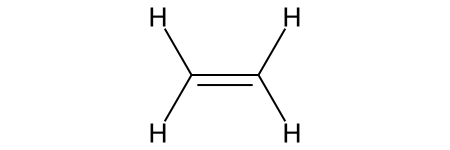

In [12]:
cpnds['C2H4'].atXYZ.isel(frame=0).sh.to_mol()

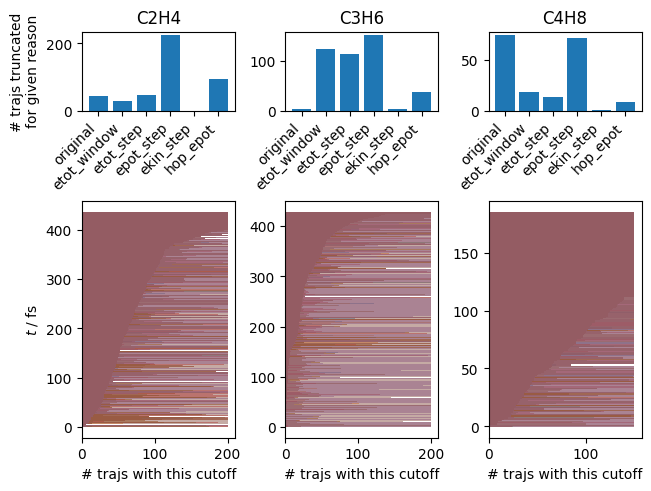

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, sharey=False, constrained_layout=True, height_ratios=[1, 3])
for (cn, c), axcol in zip(cutoffs.items(), axs.T):
    nreasons = c.sizes['cutoff']
    typefreqs = np.bincount(c.argmin('cutoff'), minlength=nreasons)
    xticks = range(nreasons)
    axcol[0].bar(xticks, typefreqs)
    axcol[0].set_xticks(xticks)
    axcol[0].set_xticklabels(labels=c['cutoff'].data, rotation=45, ha='right')
    axcol[0].set_title(cn)

    c = c.sortby([c.min('cutoff'), c.sel(cutoff='original')])
    xticks = np.arange(c.sizes['trajid'])
    for ctn, ctv in c.groupby('cutoff'):
        ctv = ctv.squeeze()
        axcol[1].barh(xticks, ctv, height=1.0, alpha=0.5)
    
    axs[0,0].set_ylabel("# trajs truncated\nfor given reason")
    axs[1,0].set_ylabel("$t$ / fs")
    for ax in axs[1, :]:
        ax.set_xlabel("# trajs with this cutoff")

In [4]:
cutoffs = {}
for cpnd in cpnds:
    feat = cpnds[cpnd].sh.energy_filtranda()
    cutoffs[cpnd] = xr.Dataset(
        {
            'etot_window' : abs(feat['etot_drift']) < 0.2,
            'etot_step'   : abs(feat['etot_step']) < 0.1,
            'epot_step'   : (abs(feat['epot_step']) < 0.7) | feat['is_hop'],
            'ekin_step'   : (abs(feat['ekin_step']) < 0.7) | feat['is_hop'],
            'hop_epot'    : (abs(feat['epot_step']) < 1.0) | ~feat['is_hop'],
        }
    ).sh.get_cutoffs()

In [6]:
cutoffs['C2H4'].to_pandas()

,original,etot_window,etot_step,epot_step,ekin_step,hop_epot,earliest,reason
trajid_,,,,,,,,
2,200.0,84.0,83.5,84.0,83.5,162.0,83.5,2
3,200.0,143.0,122.5,109.0,109.0,200.0,109.0,3
4,200.0,140.5,140.5,94.0,94.0,200.0,94.0,3
5,200.0,200.0,135.0,106.0,106.0,30.5,30.5,5
7,200.0,28.0,28.0,48.5,48.5,200.0,28.0,1
...,...,...,...,...,...,...,...,...
957,200.0,200.0,200.0,72.5,72.5,200.0,72.5,3
958,200.0,138.5,138.5,56.0,66.5,49.5,49.5,5
959,200.0,181.5,58.5,39.0,39.0,200.0,39.0,3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, sharey=False, constrained_layout=True, height_ratios=[1, 3])
for (cn, c), axcol in zip(cutoffs.items(), axs.T):
    nreasons = len(c.attrs['reasons'])
    typefreqs = np.bincount(c['reason'], minlength=nreasons)
    xticks = range(nreasons)
    axcol[0].bar(xticks, typefreqs)
    axcol[0].set_xticks(xticks)
    axcol[0].set_xticklabels(labels=c.attrs['reasons'], rotation=45, ha='right')
    axcol[0].set_title(cn)

    da = c.to_dataarray('cutoff').sortby([c['earliest'], c['original']])
    xticks = np.arange(da.sizes['trajid_'])
    for ctn, ctv in da.groupby('cutoff'):
        ctv = ctv.squeeze()
        axcol[1].barh(xticks, ctv, height=1.0, alpha=0.5)
    
    axs[0,0].set_ylabel("# trajs truncated\nfor given reason")
    axs[1,0].set_ylabel("$t$ / fs")
    for ax in axs[1, :]:
        ax.set_xlabel("# trajs with this cutoff")

In [ ]:
efilt = {c: cpnds[c].sh.truncate(cutoffs[c]['earliest']) for c in cpnds}
efilt['C2H4']

## Eliminate overshort trajectories

In [ ]:
efilt = {c: cpnds[c].sh.truncate(cutoffs[c]['earliest']) for c in cpnds}

for cpnd in efilt:
    threshold = cpnds[cpnd].coords['time'].max() * 0.25
    last_times = efilt[cpnd].time.groupby('trajid').last()
    osids = last_times[last_times < threshold].trajid
    print(cpnd, ':', len(osids))
    efilt[cpnd] = efilt[cpnd].sh.sel_trajs(osids, invert=True)

## Summarize: numbers of trajetories and frames

In [ ]:
for cpnd in cpnds:
    print(cpnd)
    b = cpnds[cpnd].sizes
    a = efilt[cpnd].sizes
    for x in ['trajid_', 'frame']:
        print(f"{x:<7} {b[x]:6} -> {a[x]: 6}  retaining {100*a[x]/b[x]:05.2f}%")

    print()

### Checkpoint: filtration complete

In [ ]:
for cpnd in cpnds:
    efilt[cpnd].sh.save_frames(f'/tmp/filtered_{cpnd}.nc')

In [ ]:
import shnitsel.dynamic as sh
import shnitsel.dynamic.postprocess as P
import matplotlib.pyplot as plt
import numpy as np
filtered = {}
for cpnd in ['C2H4', 'C3H6', 'C4H8']:
    filtered[cpnd] = sh.xrhelpers.open_frames(f'/tmp/filtered_{cpnd}.nc')

### Butene only: remove cleavages for biplot
Because plotting dihedral rather than bodn-length

In [ ]:
# borrowed from shnitsel-rough/pipelin.ipynb -- consider canonicalizing
def scope(cpnd):
    # We begin with S2 removed.
    ids = {}
    ids['withCH'] = sh.filter_unphysical.find_overlong(cpnd['atXYZ'], 1, 6, cutoff=1.7)
    ids['withCC'] = sh.filter_unphysical.find_overlong(cpnd['atXYZ'], 6, 6, cutoff=2.8)
    ids['withCHorCC'] = list(set(ids['withCH']).union(ids['withCC']))
    ids['withCHandCC'] = list(set(ids['withCH']).intersection(ids['withCC']))
    print(f"{ids['withCC']=}")
    print(f"{ids['withCHandCC']=}")

    removed_trajs = {k: sh.xrhelpers.sel_trajids(cpnd, v) for k, v in ids.items()}
    removed = {k: [v.sizes['frame'], len(np.unique(v.trajid))] for k, v in removed_trajs.items()}
    remaining_trajs = {k: sh.xrhelpers.sel_trajids(cpnd, v, invert=True) for k, v in ids.items()}
    remaining = {k: [v.sizes['frame'], len(np.unique(v.trajid))] for k, v in remaining_trajs.items()}
    
    return removed, remaining

scope(filtered['C4H8_g0'])

In [ ]:
mol = sh.filter_unphysical.mol_from_atXYZ(
    filtered['C4H8_g0'].atXYZ.isel(frame=0), to2D=False
)
filtered['C4H8_g0'].atXYZ.attrs['smiles_map'] = sh.filter_unphysical.mol_to_numbered_smiles(mol)

uncleaving = sh.filter_unphysical.filter_cleavage(filtered['C4H8_g0'], CC=True, CH=True)
uncleaving

In [ ]:
folder = '/nc/reports/2025-05-21_datasheets/plots'
sh.plot.biplot_kde(frames=uncleaving, at1=0, at2=1, at3=2, at4=3, geo_filter=[[0,70],[90,180]], levels=8)
plt.gcf().savefig(f'{folder}/kb_C4H8_g0.png')

In [ ]:
sh.plot.biplot_kde(frames=uncleaving, at1=0, at2=1, at3=2, at4=3, geo_filter=[[0,70],[90,180]], levels=8)

### Checkpoint

In [ ]:
uncleaving.sh.save_frames('/tmp/uncleaving.nc')